# Annotate merged single cells with metadata from platemap file

## Import libraries

In [18]:
import argparse
import pathlib
import sys

import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from pycytominer import annotate
from pycytominer.cyto_utils import output

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [19]:
def euclidean_coordinate_fuzzy_match(
    df_left: pd.DataFrame,
    df_right: pd.DataFrame,
    left_on: list,
    right_on: list,
    coordinate_column: str,
    pixel_cutt_off: int = 5,
) -> pd.DataFrame:
    """
    This function fuzzy merges two dataframes based on the euclidean distance between the coordinates in the coordinate_column.

    Parameters
    ----------
    df_left : pd.DataFrame
        left dataframe to merge
    df_right : pd.DataFrame
        right dataframe to merge
    left_on : list
        Left dataframe columns to match on
    right_on : list
        Right dataframe columns to match on
    coordinate_column : str
        The column name that contains the coordinates to match on
        Note that the coordinates should be in a tuple format
    unique_image_column : str
        The column name that contains the unique image identifier to split the dataframes on
        This ensures that coordinates from other images are not matched together
    pixel_cutt_off : int
        The cut off in pixels for the euclidean distance between the coordinates
        Default is 5

    Returns
    -------
    pd.DataFrame
        A merged dataframe of the two input dataframes based on the euclidean distance between the coordinates
    """

    merged_df_list = []  # list to store the merged dataframes
    total_CP_cells = 0  # total number of cells in the left dataframe
    total_annotated_cells = 0  # total number of cells that were annotated
    distances = []  # list to store the distances between the coordinates

    total_CP_cells += df_left.shape[0]
    # loop through the rows in the subset_annotated_df and find the closest coordinate set in the location metadata
    for index1, row1 in df_left.iterrows():
        dist = np.inf
        for index2, row2 in df_right.iterrows():
            coord1 = row1[coordinate_column]
            coord2 = row2[coordinate_column]
            try:
                temp_dist = np.linalg.norm(np.array(coord1) - np.array(coord2))
            except:
                temp_dist = np.inf
            if temp_dist <= dist:
                dist = temp_dist
                coord2_index = index2

            # set cut off of 5,5 pixel in the euclidean distance
            euclidean_cut_off = np.linalg.norm(
                np.array([0, 0]) - np.array([pixel_cutt_off, pixel_cutt_off])
            )

            if dist < np.inf:
                temp_merged_df = pd.merge(
                    df_left.loc[[index1]],
                    df_right.loc[[coord2_index]],
                    how="inner",
                    left_on=right_on,
                    right_on=left_on,
                )
                distances.append(dist)
                total_annotated_cells += temp_merged_df.shape[0]
                merged_df_list.append(temp_merged_df)
    if len(merged_df_list) == 0:
        return pd.DataFrame()
    merged_df = pd.concat(merged_df_list)
    merged_df["distance"] = distances
    print(f"Percentage of annotated cells: {total_annotated_cells/total_CP_cells*100}%")
    return merged_df

## Set paths and variables

In [44]:
# load in platemap file as a pandas dataframe
platemap_path = pathlib.Path("../../data/").resolve()

# directory where parquet files are located
data_dir = pathlib.Path("../data/converted_data").resolve()

# directory where the annotated parquet files are saved to
output_dir = pathlib.Path("../data/annotated_data")
output_dir.mkdir(exist_ok=True)

if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Single cell extraction")

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    well_fov = args.well_fov
    images_dir = pathlib.Path(data_dir / well_fov).resolve(strict=True)
else:
    print("Running in a notebook")
    well_fov = "C-02_F0001"

Running in a notebook


In [45]:
# dictionary with each run for the cell type
dict_of_inputs = {
    "run_20231017ChromaLive_6hr_4ch_MaxIP": {
        "input_file": pathlib.Path(
            f"{output_dir}/timelapse/{well_fov}_sc.parquet"
        ).resolve(),
    },
    "20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP": {
        "input_file": pathlib.Path(
            f"{output_dir}/endpoint/{well_fov}_sc.parquet"
        ).resolve(),
    },
}

## Annotate merged single cells

### Merge the terminal and single cell data

## Add the object tacking from SAM2

### Loop through the saved annotated dfs and add the object tracking

In [66]:
path = pathlib.Path(f"{output_dir}/timelapse/{well_fov}_sc.parquet").resolve()
ultracks_path = pathlib.Path(
    f"../../4.cell_tracking/results/{well_fov}_tracks.parquet"
).resolve()
sam_tracks_path = pathlib.Path(
    f"../../4.cell_tracking/results/{well_fov}_sam_tracks.parquet"
).resolve()
df = pd.read_parquet(
    path,
    columns=["Metadata_Time", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y"],
)
pd.options.display.max_columns = None
# remove the leading zeros from the time column
df["Metadata_Time"] = df["Metadata_Time"].str.lstrip("0")
time = df.pop("Metadata_Time")
df.insert(0, "Metadata_Time", time)
df["Metadata_Time"] = df["Metadata_Time"].astype(float)
df["coordinates"] = list(
    zip(df["Nuclei_AreaShape_Center_X"], df["Nuclei_AreaShape_Center_Y"])
)
# sort by coordinates
df = df.sort_values(by=["Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y"])
df.head()

,Metadata_Time,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,coordinates
334,2.0,3.427245,1699.371517,"(3.4272445820433437, 1699.3715170278638)"
840,7.0,5.019886,1499.295455,"(5.019886363636363, 1499.2954545454545)"
1059,10.0,6.422840,16.354938,"(6.422839506172839, 16.354938271604937)"
1813,4.0,6.558468,284.084677,"(6.558467741935484, 284.0846774193548)"
70,1.0,7.411504,654.738938,"(7.411504424778761, 654.7389380530974)"


In [67]:
ultracks_df = pd.read_parquet(ultracks_path)
ultracks_df["coordinates"] = list(zip(ultracks_df["x"], ultracks_df["y"]))
ultracks_df = ultracks_df.sort_values(by=["x", "y"])
# transform the coordinates to flip the y axis
ultracks_df.head()

,track_id,t,y,x,id,parent_track_id,parent_id,coordinates
542,47,3.0,284.0,7.0,4000037.0,-1,3000030.0,"(7.0, 284.0)"
541,47,2.0,288.0,8.0,3000030.0,-1,2000030.0,"(8.0, 288.0)"
1469,136,10.0,1553.0,8.0,11000129.0,-1,10000131.0,"(8.0, 1553.0)"
543,47,4.0,280.0,9.0,5000033.0,-1,4000037.0,"(9.0, 280.0)"
544,47,5.0,284.0,15.0,6000032.0,-1,5000033.0,"(15.0, 284.0)"


In [68]:
ultracks_df = ultracks_df.loc[ultracks_df["t"] == 1.0]
df = df.loc[df["Metadata_Time"] == 1.0]

In [70]:
import skimage.io

image = "../../2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001/C-02_F0001_T0001_Z0001_nuclei_mask.tiff"
image = skimage.io.imread(image)

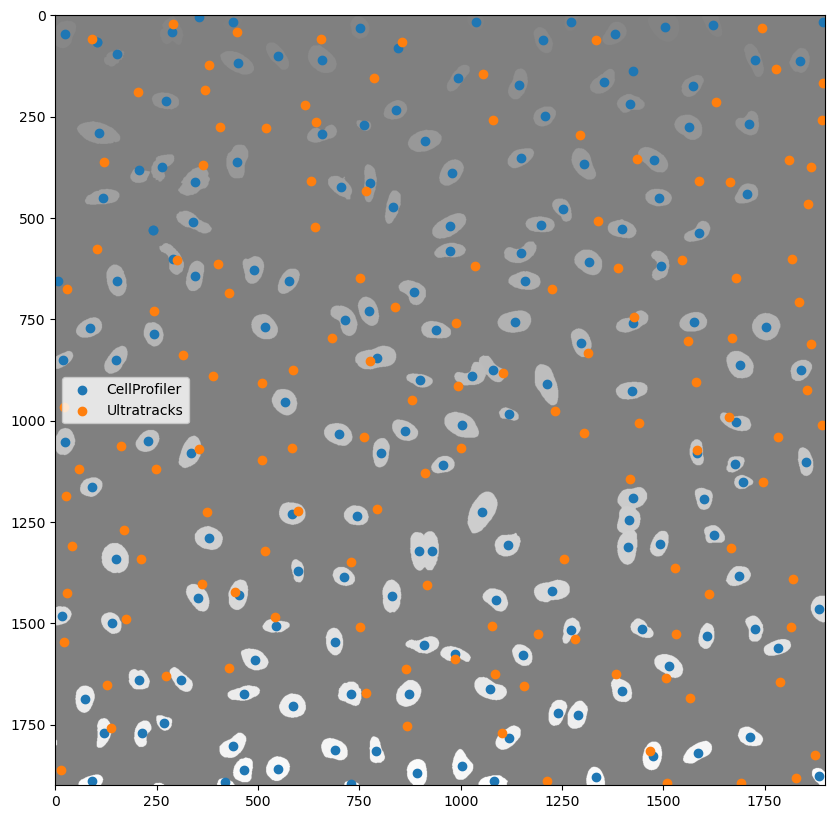

In [73]:
# plot both the x and y coordinates from both dfs
plt.figure(figsize=(10, 10))
plt.scatter(
    df["Nuclei_AreaShape_Center_X"],
    df["Nuclei_AreaShape_Center_Y"],
    label="CellProfiler",
)
plt.scatter(ultracks_df["y"], ultracks_df["x"], label="Ultratracks")
plt.imshow(image, cmap="gray", alpha=0.5)
# invert the y axis
plt.legend()
plt.show()

In [53]:
merged_df_list = []  # list to store the merged dataframes
total_CP_cells = 0  # total number of cells in the left dataframe
total_annotated_cells = 0  # total number of cells that were annotated
distances = []  # list to store the distances between the coordinates
df_left = df.copy()
df_right = ultracks_df.copy()
left_on = "Metadata_Time"
right_on = "t"
coordinate_column = "coordinates"
pixel_cutt_off = 10
euclidean_cut_off = np.linalg.norm(
    np.array([0, 0]) - np.array([pixel_cutt_off, pixel_cutt_off])
)

total_CP_cells += df_left.shape[0]
timepoints = df["Metadata_Time"].unique()
# for timepoint in timepoints:
#     df_left_subset = df_left[df_left["Metadata_Time"] == timepoint]
#     df_right_subset = df_right[df_right["t"] == timepoint]
# df_left_subset = df_left[df_left["Metadata_Time"] == timepoints[0]]
# df_right_subset = df_right[df_right["t"] == timepoints[0]]
df_left_subset = df_left
df_right_subset = df_right
# loop through the rows in the subset_annotated_df and find the closest coordinate set in the location metadata
for index1, row1 in tqdm.tqdm(
    df_left_subset.iterrows(), total=len(df_left_subset), desc="df_left_subset"
):
    dist = np.inf
    for index2, row2 in tqdm.tqdm(
        df_right_subset.iterrows(),
        total=len(df_right_subset),
        desc="df_right_subset",
        leave=False,
    ):
        coord1 = row1[coordinate_column]
        coord2 = row2[coordinate_column]
        try:
            temp_dist = np.linalg.norm(np.array(coord1) - np.array(coord2))
        except:
            temp_dist = np.inf

    if temp_dist <= dist:
        dist = temp_dist
        coord2_index = index2
    # set cut off of 5,5 pixel in the euclidean distance

    if dist < euclidean_cut_off:
        print(dist, euclidean_cut_off)
        temp_merged_df = pd.merge(
            df_left_subset.loc[[index1]],
            df_right_subset.loc[[coord2_index]],
            how="inner",
            left_on=left_on,
            right_on=right_on,
        )
        distances.append(dist)
        total_annotated_cells += temp_merged_df.shape[0]
        merged_df_list.append(temp_merged_df)
print(len(merged_df_list))

df_left_subset:  96%|█████████▌| 2216/2309 [02:30<00:06, 14.43it/s]

0.6358747790987446 14.142135623730951


df_left_subset: 100%|██████████| 2309/2309 [02:36<00:00, 14.71it/s]

1


In [54]:
merged_df = pd.concat(merged_df_list)
merged_df["distance"] = distances
# round the distance to 2 decimal places
print(
    f"Percentage of annotated cells: {np.round(total_annotated_cells/total_CP_cells*100,2)}%"
)

Percentage of annotated cells: 0.0%


In [ ]:
try:
    temp_dist = np.linalg.norm(np.array(coord1) - np.array(coord2))
except:
    temp_dist = np.inf
if temp_dist <= dist:
    dist = temp_dist
    coord2_index = index2

# set cut off of 5,5 pixel in the euclidean distance
euclidean_cut_off = np.linalg.norm(
    np.array([0, 0]) - np.array([pixel_cutt_off, pixel_cutt_off])
)

if dist < np.inf:
    temp_merged_df = pd.merge(
        df_left.loc[[index1]],
        df_right.loc[[coord2_index]],
        how="inner",
        left_on=right_on,
        right_on=left_on,
    )
    distances.append(dist)
    total_annotated_cells += temp_merged_df.shape[0]
    merged_df_list.append(temp_merged_df)

merged_df = pd.concat(merged_df_list)
merged_df["distance"] = distances
print(f"Percentage of annotated cells: {total_annotated_cells/total_CP_cells*100}%")

Location metadata shape for run_20231017ChromaLive_6hr_4ch_MaxIP is (14882, 9)
/home/lippincm/Documents/live_cell_timelapse_apoptosis/5.process_CP_features/data/annotated_data/run_20231017ChromaLive_6hr_4ch_MaxIP_sc.parquet
Oringinal shape of run_20231017ChromaLive_6hr_4ch_MaxIP is (19382, 2325)
There were 4807 NaN values in the centroid columns
(14575, 2328) (14882, 11)


/tmp/ipykernel_261847/1581231095.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['distance'] = distances


Percentage of annotated cells: 100.0%
(14575, 2334)
The average distance between the annotated and CP data is 5.293905628142523
The std of the distance between the annotated and CP data is 5.516932893853417
The threshold for the distance between the annotated and CP data is 16.327771415849355


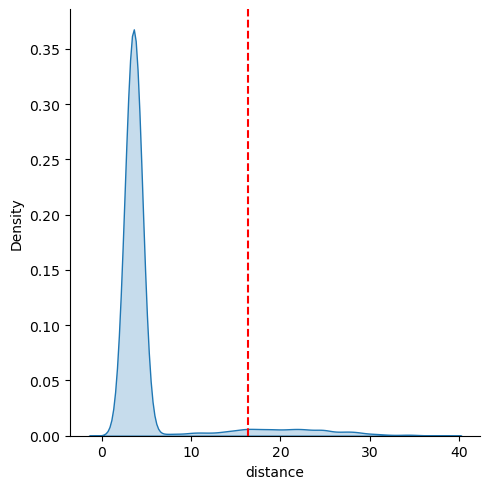

Removed 1078 cells above the threshold
Location metadata shape for 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP is (675, 9)
/home/lippincm/Documents/live_cell_timelapse_apoptosis/5.process_CP_features/data/annotated_data/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_sc.parquet
Oringinal shape of 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP is (838, 1208)
There were 149 NaN values in the centroid columns
(689, 1211) (675, 11)
Percentage of annotated cells: 100.0%
(689, 1217)
Removed 356 cells above the threshold


/tmp/ipykernel_261847/1581231095.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['distance'] = distances


In [6]:
for data_run in dict_of_inputs.keys():
    ##############################################
    # load in location metadata file as a pandas dataframe
    # set and connect to the db
    # create the database object
    uri = pathlib.Path("../../data/objects_db").resolve()
    db = lancedb.connect(uri)
    # load table
    table = db["1.masked_images"]
    location_metadata_df = table.to_pandas()
    location_metadata_df.head()
    # change frame to Metadata_Time
    location_metadata_df = location_metadata_df.rename(
        columns={"frame": "Metadata_Time"}
    )
    # add 1 to Metadata_Time to match the timepoints in the single cell data
    location_metadata_df["Metadata_Time"] = location_metadata_df["Metadata_Time"] + 1
    # change formatting to leading 4 zeros
    location_metadata_df["Metadata_Time"] = location_metadata_df["Metadata_Time"].apply(
        lambda x: f"{x:04}"
    )
    location_metadata_df["Metadata_unique_cell_name"] = (
        location_metadata_df["image_set_name"]
        + "_"
        + location_metadata_df["object_id"].astype(str)
    )
    for col in location_metadata_df.columns:
        if not col.startswith("Metadata_"):
            location_metadata_df = location_metadata_df.rename(
                columns={col: f"Metadata_{col}"}
            )

    ##############################################
    if "endpoint" in data_run:
        # get only the endpoint timepoint for the endpoint data
        location_metadata_df = location_metadata_df[
            location_metadata_df["Metadata_Time"] == "0014"
        ]
    elif "endpoint" not in data_run:
        # remove the endpoint timepoint for the 6hr data
        location_metadata_df = location_metadata_df[
            location_metadata_df["Metadata_Time"] != "0014"
        ]
    print(f"Location metadata shape for {data_run} is {location_metadata_df.shape}")
    # load in annotated parquet file as df to use in annotate function
    annotated_df_path = pathlib.Path(f"{output_dir}/{data_run}_sc.parquet").resolve(
        strict=True
    )
    output_file = annotated_df_path

    print(annotated_df_path)
    annotated_df = pd.read_parquet(annotated_df_path)
    print(f"Original shape of {data_run} is {annotated_df.shape}")

    annotated_df["Metadata_image_set_name"] = (
        annotated_df["Metadata_Well"].astype(str)
        + "_"
        + "F"
        + annotated_df["Metadata_FOV"].astype(str)
    )

    image_set_names = annotated_df.pop("Metadata_image_set_name")
    # move to front
    time = annotated_df.pop("Metadata_Time")
    x_coord = annotated_df.pop("Metadata_Nuclei_Location_Center_X")
    y_coord = annotated_df.pop("Metadata_Nuclei_Location_Center_Y")

    annotated_df = pd.concat(
        [image_set_names, annotated_df, time, x_coord, y_coord], axis=1
    )

    num_cells_over_time = annotated_df.shape[0]
    # drop NaN values in the centroid columns from annotated_df
    annotated_df = annotated_df.dropna(
        subset=[
            "Metadata_Nuclei_Location_Center_X",
            "Metadata_Nuclei_Location_Center_Y",
        ]
    )
    print(
        f"There were {num_cells_over_time - annotated_df.shape[0]} NaN values in the centroid columns"
    )

    # round the float coordinates to integers
    annotated_df["Metadata_Nuclei_Location_Center_X"] = (
        annotated_df["Metadata_Nuclei_Location_Center_X"].round(0).astype(int)
    )
    annotated_df["Metadata_Nuclei_Location_Center_Y"] = (
        annotated_df["Metadata_Nuclei_Location_Center_Y"].round(0).astype(int)
    )

    location_metadata_df["Metadata_x"] = location_metadata_df["Metadata_x"].astype(int)
    location_metadata_df["Metadata_y"] = location_metadata_df["Metadata_y"].astype(int)

    # Create new columns in a separate DataFrame
    new_columns = pd.DataFrame(
        {
            "Metadata_individual_images": annotated_df["Metadata_image_set_name"]
            + "_"
            + annotated_df["Metadata_Time"].astype(str),
            "Metadata_coordinates": list(
                zip(
                    annotated_df["Metadata_Nuclei_Location_Center_X"],
                    annotated_df["Metadata_Nuclei_Location_Center_Y"],
                )
            ),
        }
    )

    # Concatenate the new columns with the original DataFrame
    annotated_df = pd.concat([annotated_df, new_columns], axis=1)

    location_metadata_df["Metadata_individual_images"] = (
        location_metadata_df["Metadata_image_set_name"]
        + "_"
        + location_metadata_df["Metadata_Time"].astype(str)
    )
    location_metadata_df["Metadata_coordinates"] = list(
        zip(location_metadata_df["Metadata_x"], location_metadata_df["Metadata_y"])
    )

    print(annotated_df.shape, location_metadata_df.shape)

    # the terminal data shifted largely due to the plate being moved!
    # dead cells really shifted and are no longer in the same location or close and thus not trackable

    merged_df = euclidean_coordinate_fuzzy_match(
        df_left=annotated_df,
        df_right=location_metadata_df,
        left_on=[
            "Metadata_individual_images",
            "Metadata_Time",
            "Metadata_image_set_name",
        ],
        right_on=[
            "Metadata_individual_images",
            "Metadata_Time",
            "Metadata_image_set_name",
        ],
        coordinate_column="Metadata_coordinates",
        unique_image_column="Metadata_individual_images",
    )
    if merged_df.empty:
        print(f"No cells were matched for {data_run}")
        continue
    # sort by image_set_name and Metadata_Time
    merged_df = merged_df.sort_values(by=["Metadata_image_set_name", "Metadata_Time"])
    merged_df = merged_df.drop(
        columns=[
            "Metadata_individual_images",
            "Metadata_coordinates_x",
            "Metadata_coordinates_y",
        ]
    )
    print(merged_df.shape)
    # this sets the threshold for the main dataset and applies it to the endpoint dataset

    threshold = 14
    if not "endpoint" in data_run:

        # find the density average of the distance
        print(
            f"The average distance between the annotated and CP data is {merged_df['distance'].mean()}"
        )
        # find the std of the distance
        print(
            f"The std of the distance between the annotated and CP data is {merged_df['distance'].std()}"
        )
        # set the threshold to mean + 2*std
        threshold = merged_df["distance"].mean() + 2 * merged_df["distance"].std()
        print(
            f"The threshold for the distance between the annotated and CP data is {threshold}"
        )

        # density plot of the annotated data
        sns.displot(merged_df["distance"], kind="kde", fill=True)
        # add the threshold line
        plt.axvline(x=threshold, color="red", linestyle="--")
        plt.show()
        # remove the cells that are above the threshold
    number_of_cells = merged_df.shape[0]
    merged_df = merged_df[merged_df["distance"] <= threshold]
    print(f"Removed {number_of_cells - merged_df.shape[0]} cells above the threshold")
    # save annotated df as parquet file
    output(
        df=merged_df,
        output_filename=output_file,
        output_type="parquet",
    )
    del merged_df
    del annotated_df
    del location_metadata_df